# À propos de ce livret




*Utilisation d'une méthode de base.*




### Recherches
>Renaud Gaujoux, Cathal Seoighe (2010). **A flexible R package for nonnegative matrix factorization.**  
>Xihui Lin, Paul C. Boutros (2020). [**Optimization and expansion of non-negative matrix factorization.**](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6945623/)

### Sources
>[**Dépôt 1**](https://github.com/linxihui/NNLM) | *Version R*  
>[**Dépôt 2**](https://github.com/timothyliu-datascience/Non-negative-Matrix-Factorization/blob/master/NMFN.R) | *Version R*  




### Note sur le cachier
- Ajouter la recherche du rang 
- Modulariser les éléments

>[**Exemples d'implémentation**](https://rdrr.io/cran/NNLM/f/inst/doc/Fast-And-Versatile-NMF.pdf)  | *Document explicatif*



- Voir le RMSE


## Préparation pour l'utilisation

In [1]:
## load up the packages we will need:  (uncomment as required)

library(R.matlab)
pac = c("devtools", "R.matlab", "plyr", "ggplot2")

# Installer les paquets s'ils sont manquants
new_pac <- pac[!(pac %in% installed.packages()[, "Package"])]
if (length(new_pac))
  install.packages(new_pac)

library (plyr)

library(ggplot2)

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.


Attaching package: 'R.matlab'


The following objects are masked from 'package:base':

    getOption, isOpen




# Données

## Chargement des données

In [2]:
# Test avec Seattle 50 % avec 50 % de manquants
dossier <- "transport_Seattle/" # utilisé pour sauvegarder les données également
dossier_donnees <- paste0("data/", dossier)
fichier.complet <- "seattle_mat50"
fichier.binaire <- paste0(fichier.complet, "bin50")

In [3]:
mat.complet <- readMat(paste0(dossier_donnees, fichier.complet, ".mat"))
mat.complet <- mat.complet$mat
mat.binaire <- readMat(paste0(dossier_donnees, fichier.binaire, ".mat"))
mat.binaire <- mat.binaire$mat

## Création de la matrice de manquants

In [4]:
# Création de la matrice de manquants
manq.mat <- mat.complet * mat.binaire

head(manq.mat)
dim(manq.mat)

61.93914,59.23253,61.99180,0.0000,0.00000,0.00000,0.00000,0.00000,62.73766,0.00000,...,0.00000,0.00000,0.00000,61.89478,0.00000,64.51251,62.82222,0.00000,62.52052,0.00000
0.00000,65.08245,65.30912,0.0000,65.28767,68.00123,0.00000,66.76399,0.00000,0.00000,...,0.00000,66.22647,0.00000,0.00000,68.16688,0.00000,0.00000,69.54091,0.00000,63.69065
0.00000,0.00000,0.00000,67.2066,0.00000,66.41280,0.00000,0.00000,66.56429,65.28691,...,66.48719,66.83091,0.00000,0.00000,0.00000,66.12682,0.00000,0.00000,68.68083,63.33837
60.78642,0.00000,0.00000,0.0000,64.70741,62.72487,62.48182,63.42375,0.00000,64.77862,...,0.00000,64.94116,64.35695,63.84595,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
63.12068,0.00000,0.00000,0.0000,65.70866,63.67469,0.00000,0.00000,62.62986,0.00000,...,0.00000,66.43643,64.82368,0.00000,63.04948,64.79836,66.15399,0.00000,63.58042,0.00000
0.00000,62.49672,63.81661,0.0000,0.00000,63.12397,0.00000,65.14970,0.00000,63.31650,...,0.00000,63.38139,64.03708,63.67491,0.00000,62.02703,64.62548,0.00000,62.45866,61.03024


[1]  162 4032

In [5]:
# Créer un index pour la validation des paramètres imputés
index <- which(mat.binaire %in% c(0))

# Modélisation

### Fonctions d'utilités

In [6]:
# Moore-Penrose Inverse
mpinv <- function(X) {
    Eps <- 100 * .Machine$double.eps
    
    # singular value decomposition
    s <- svd(X)
    d <- s$d
    m <- length(d)
    
    if (!(is.vector(d))) 
        return(t(s$v %*% (1/d) %*% t(s$u)))
    
    d <- d[d > Eps]
    notnull <- length(d)
    
    if (notnull == 1) {
        inv <- 1/d
    } else {
        inv <- solve(diag(d))
    }
    
    if (notnull != m) {
        inv <- cbind(inv, matrix(0, nrow = notnull, ncol = (m - notnull)))
        inv <- rbind(inv, matrix(0, nrow = (m - notnull), ncol = m))
    }
    
    mp <- s$v %*% inv %*% t(s$u)
    
    mp[abs(mp) < Eps] <- 0
    return(mp)
}

In [7]:
# Euclidean Distance between two matrices
distance2 <- function(x1, x2) {
    temp <- x1 - x2
    sum(temp * temp)
}

In [8]:
# RMSE sur les valeurs de la matrice binaire
RMSE <- function(val_orig, val_pred, index) {
    sqrt(mean((val_orig[index] - val_pred[index])^2))
}

## Modèles

In [9]:
# Non-negative Matrix Factorization via alternating least squares
nnmf_als <- function(x, k, maxiter, eps, index, x_complet) {
    print_iter <- 50  # iterations between print
    x <- as.matrix(x)
    
    if (any(!is.finite(x))) 
        stop("infinite or missing values in 'x'")
    
    dx <- dim(x)
    D <- dx[1L]
    N <- dx[2L]
    Xscale = sum(x)
    
    
    if (!D || !N) 
        stop("0 extent dimensions")
    set.seed(2020)
    W <- matrix(abs(rnorm(D * k)), D, k)
    set.seed(2020)
    H <- matrix(abs(rnorm(k * N)), k, N)
    
    Rscale <- sum(W %*% H)
    sqrnorm <- sqrt(Rscale/Xscale)
    
    H <- H/sqrnorm
    W <- W/sqrnorm
    
    Xr_old <- W %*% H
    
    for (iter in 1:maxiter) {
        W <- x %*% t(mpinv(H %*% t(H)) %*% H)
        W <- (W > 0) * W
        W <- W/(t(matrix(rep(colSums(W), D), ncol(W), nrow(W))) + eps)
        H <- t(W %*% mpinv(t(W) %*% W)) %*% x
        H <- H * (H > 0)
        
        if (iter%%print_iter == 0) {
            Xr <- W %*% H
            diff <- sum(abs(Xr_old - Xr))
            Xr_old <- Xr
            
            eucl_dist <- distance2(x, W %*% H)
            errorx <- mean(abs(x - W %*% H))/mean(x)
            x_pred = W %*% H
            rmsex <- sqrt(mean((x_complet[index] - x_pred[index])^2))
            
            cat("Iter = ", iter, "\t")
            cat("relative error = ", errorx, "\t")
            cat("RMSE", rmsex, "\t")
            cat("diff = ", diff, "\t")
            cat("eucl dist = ", eucl_dist, "\n")
            
            if (errorx < 1e-05) {
                cat("Execution finishes at iteration = ", iter, "\n")
                break
            }
        }
    }
    z <- c(list(W = W, H = H))
    z
}

In [10]:
# Non-negative Matrix Factorization via multiplicative update
nnmf_mm <- function(x, k, maxiter, eps, index, x_complet) {
    print_iter <- 50  # iterations between print
    x <- as.matrix(x)
    
    if (any(!is.finite(x))) 
        stop("infinite or missing values in 'x'")
    
    dx <- dim(x)
    n <- dx[1L]
    m <- dx[2L]
    
    if (!n || !m) 
        stop("0 extent dimensions")
    
    set.seed(2020) # Reproductibitlité
    W <- matrix(abs(rnorm(n * k)), n, k)
    set.seed(2020) # Reproductibitlité
    H <- matrix(abs(rnorm(k * m)), k, m)
    
    Xr_old <- W %*% H
    
    for (iter in 1:maxiter) {
        H <- H * (t(W) %*% x)/((t(W) %*% W) %*% H + eps)
        W <- W * t(H %*% t(x))/(W %*% (H %*% t(H)) + eps)
        
        if (iter%%print_iter == 0) {
            Xr <- W %*% H
            diff <- sum(abs(Xr_old - Xr))
            Xr_old <- Xr
            
            
            eucl_dist <- distance2(x, W %*% H)
            errorx <- mean(abs(x - W %*% H))/mean(x)
            x_pred = W %*% H
            rmsex <- sqrt(mean((x_complet[index] - x_pred[index])^2))
            
            cat("Iter = ", iter, "\t")
            cat("relative error = ", errorx, "\t")
            cat("RMSE", rmsex, "\t")
            cat("diff = ", diff, "\t")
            cat("eucl dist = ", eucl_dist, "\n")
            
            if (errorx < 1e-05) {
                cat("Execution finishes at iteration = ", iter, "\n")
                break
            }
        }
    }
    
    z <- c(list(W = W, H = H))
    z
}

In [11]:
# Non-negative Matrix Factorization via multinomial
nnmf_prob <- function(x, k, maxiter, eps = 100 * .Machine$double.eps, index, x_complet) {
    print_iter <- 50
    powers <- 1.5 + (2.5 - 1.5) * ((1:maxiter) - 1)/(maxiter - 1)
    
    D <- dim(x)[1L]
    N <- dim(x)[2L]
    
    X_factor <- sum(x)
    X_org <- x
    x <- x/X_factor
    
    set.seed(2020) # Reproductibitlité
    W <- matrix(abs(rnorm(D * k)), D, k)
    W <- W/t(matrix(rep(colSums(W), D), ncol(W), nrow(W)))
    set.seed(2020) # Reproductibitlité
    H <- matrix(abs(rnorm(k * N)), k, N)
    H <- H/(matrix(rep(rowSums(H), N), nrow(H), ncol(H)))
    
    P <- matrix(rep(1), k, 1)
    P <- P/sum(P)
    
    W1 <- W
    H1 <- H
    
    Xr_old <- W %*% H
    
    for (iter in 1:maxiter) {
        Qnorm <- (W %*% diag(diag(P), k, k)) %*% H
        
        for (j in 1:k) {
            Q <- (t(t(W[, j])) %*% H[j, ] * P[j])/(Qnorm + eps)
            XQ <- x * Q
            
            dummy <- rowSums(XQ)
            W1[, j] <- t(dummy/sum(dummy))
            
            dummy <- colSums(XQ)
            H1[j, ] <- (dummy/sum(dummy))
            
        }
        W <- W1
        H <- H1
        
        if (iter%%print_iter == 0) {
            Xr <- W %*% H
            diff <- sum(abs(Xr_old - Xr))
            Xr_old <- Xr
            
            eucl_dist <- distance2(x, W %*% H)
            errorx <- mean(abs(x - W %*% H))/mean(x)
            
            x_pred = W %*% H
            rmsex <- sqrt(mean((x_complet[index] - x_pred[index])^2))
            
            cat("Iter = ", iter, "\t")
            cat("relative error = ", errorx, "\t")
            cat("RMSE", rmsex, "\t")
            cat("diff = ", diff, "\t")
            cat("eucl dist = ", eucl_dist, "\n")
            
            if (errorx < 1e-05) {
                cat("Execution finishes at iteration = ", iter, "\n")
                break
            }
        }
    }
    
    W <- W %*% diag(diag(sqrt(P)), k, k) * X_factor
    H <- diag(diag(sqrt(P)), k, k) %*% H
    
    z <- c(list(W = W, H = H))
    z
}

In [12]:
## Fonction pour le choix d'entrainement main function of Non-negative Matrix
## Factorization
nnmf <- function(x, k, method = "nnmf_mm", maxiter = 1000, eps = 2.2204e-16, index, x_complet) {
    if (method == "nnmf_als") {
        cat("Alternating Least Squares Algorithm", "\n")
        nnmf_als(x, k, maxiter, eps, index, x_complet)
        
    } else if (method == "nnmf_prob") {
        cat("Multinomial Algorithm", "\n")
        nnmf_prob(x, k, maxiter, eps, index, x_complet)
        
    } else {
        cat("Multiplicative Update Algorithm", "\n")
        nnmf_mm(x, k, maxiter, eps, index, x_complet)
    }
}

# Entrainement

## Entrainement simple

In [33]:
# Entrainement simple
entrainement <- nnmf(x = manq.mat, k = 10, method = "nnmf_mm", maxiter = 1000, eps = 2.2204e-16, 
    index = index, x_complet = mat.complet)

## Sortir les matrices et les facteurs latents
U <- entrainement$W
V <- entrainement$H
mat_hat <- U %*% V

# Test avec Seattle 50 % avec 50 % de manquants
#dossier <- "transport_Seattle/" # utilisé pour sauvegarder les données également
dossier_pred <- paste0("exp/", dossier)
#fichier.complet <- "seattle_mat50"
fichier.entrainement.simple <- paste0(fichier.binaire, "_simpleFMNN.mat")

## Sauvegarde du fichier
writeMat(paste0(dossier_pred, fichier.entrainement.simple), mat = mat_hat)

Multiplicative Update Algorithm 
Iter =  50 	relative error =  0.9511352 	RMSE 32.50949 	diff =  14765787 	eucl dist =  542481467 
Iter =  100 	relative error =  0.9429004 	RMSE 32.71938 	diff =  1685077 	eucl dist =  537616354 
Iter =  150 	relative error =  0.9398576 	RMSE 32.80101 	diff =  1094112 	eucl dist =  535646279 
Iter =  200 	relative error =  0.938135 	RMSE 32.85228 	diff =  822560.2 	eucl dist =  534497591 
Iter =  250 	relative error =  0.9370202 	RMSE 32.88894 	diff =  660991.1 	eucl dist =  533729430 
Iter =  300 	relative error =  0.9363044 	RMSE 32.91509 	diff =  529230 	eucl dist =  533196442 
Iter =  350 	relative error =  0.9358283 	RMSE 32.93364 	diff =  435210.2 	eucl dist =  532799354 
Iter =  400 	relative error =  0.9354896 	RMSE 32.94888 	diff =  370891.5 	eucl dist =  532496087 
Iter =  450 	relative error =  0.9352521 	RMSE 32.9614 	diff =  308197.4 	eucl dist =  532278369 
Iter =  500 	relative error =  0.9350941 	RMSE 32.97 	diff =  266262.1 	eucl dist =

## Recherche d'hyperparamètres

In [29]:
# Recherche d'hyperparamètres
rech_hyper <- TRUE # Choisir si la recherche d'hyperparamètres doit être faite


rmse.list <- list()
method.list <- list()

## Entrainement du modèle (recherche d'hyperparamètres) Algorithmes de descente (1
## = ALS, 2 = PROB, 3 = MM)
algo = seq(1, 3, by = 1)

# Séquences de valeurs
rang = seq(5, 30, by = 20)  # k
epsilon = seq(0.1, 1, by = 0.5)  # eps (taux d'apprentissage)
max_iter = 10  # Maximum d'itérations pour l'ensemble (petit nombre d'itérations pour le moment)

In [31]:
df_hyper = data.frame()  # Pour choisir les hyperparamètres optimaux

if (rech_hyper == TRUE) {
    for (r in rang) {
        for (e in epsilon) {
            for (a in algo) {
                message(a)
                if (a == 1) {
                  algorithme = "Multiplicative"
                  message("-----------------", "\nEntrainement avec : ", "\n\tAlgorithme: ", 
                    algorithme, "\n\tRang: ", r, "\n\tEpsilon: ", e)
                  A = nnmf(x = manq.mat, k = r, method = "nnmf_mm", maxiter = max_iter, 
                    eps = e, index = index, x_complet = mat.complet)
                  # Reformer la matrice de départ
                  U = A$W
                  V = A$H
                  mat_hat <- U %*% V
                  
                  # Calculer le RMSE rmse = mean(abs(mat.complet[index] - mat_hat[index])) /
                  # mean(mat.complet[index])
                  rmse = RMSE(mat.complet, mat_hat, index)
                  message("\nRMSE: ", rmse)
                  
                  
                } else if (a == 2) {
                  algorithme = "Multinomial"
                  message("-----------------", "\nEntrainement avec : ", "\n\tAlgorithme: ", 
                    algorithme, "\n\tRang: ", r, "\n\tEpsilon: ", e)
                  A = nnmf(x = manq.mat, k = r, method = "nnmf_prob", maxiter = max_iter, 
                    eps = e, index = index, x_complet = mat.complet)
                  # Reformer la matrice de départ
                  U = A$W
                  V = A$H
                  mat_hat <- U %*% V
                  
                  # Calculer le RMSE rmse = mean(abs(mat.complet[index] - mat_hat[index])) /
                  # mean(mat.complet[index])
                  rmse = RMSE(mat.complet, mat_hat, index)
                  message(" RMSE: ", rmse)
                  
                  
                } else {
                  algorithme = "ALS"
                  message("-----------------", "\nEntrainement avec : ", "\n\tAlgorithme: ", 
                    algorithme, "\n\tRang: ", r, "\n\tEpsilon: ", e)
                  A = nnmf(x = manq.mat, k = r, method = "nnmf_als", maxiter = max_iter, 
                    eps = e, index = index, x_complet = mat.complet)
                  # Reformer la matrice de départ
                  U = A$W
                  V = A$H
                  mat_hat <- U %*% V
                  
                  # Calculer le RMSE rmse = mean(abs(mat.complet[index] - mat_hat[index])) /
                  # mean(mat.complet[index])
                  rmse = RMSE(mat.complet, mat_hat, index)
                  message(" RMSE: ", rmse)
                  
                }
                liste_hyper <- c(Rang = r, Epsilon = e, Algorithme = a, RMSE = rmse)
                liste_hyper <- t(as.data.frame(liste_hyper))
                df_hyper <- rbind(df_hyper, liste_hyper, make.row.names = FALSE)
                
            }
        }
        
        
        
        
    }
    # Réentrainer avec le modèle qui donne le plus petit RMSE
    ## Trouver le modèle
    hyper.min <- df_hyper[which.min(df_hyper$RMSE), ]
    hyper.min.list <- c(hyper.min)
    
    ## Sortir les hyperparamètres
    rang = hyper.min.list$Rang
    epsilon = hyper.min.list$Epsilon
    algorithme = hyper.min.list$Algorithme
    if (algorithme == 1) {
        algo = "nnmf_mm"
    } else if (algorithme == 2) {
        algo = "nnmf_prob"
    } else {
        algo = "nnmf_als"
    }
    
    
    ## Réentrainer avec les hyperparamètres
    entrainement <- nnmf(x = manq.mat, k = rang, method = algo, maxiter = max_iter, 
        eps = epsilon, index = index, x_complet = mat.complet)
    
    ## Sortir les matrices et les facteurs latents
    U <- entrainement$W
    V <- entrainement$H
    mat_hat <- U %*% V
    
    ## Montrer le RMSE
    rmse = RMSE(mat.complet, mat_hat, index)
    message("\nRMSE: ", rmse)
    
    
    ## Sauvegarder la matrice avec les éléments prédits
    message("\nSauvegarde de la matrice prédite")
    dossier_pred <- paste0("exp/", dossier)
    fichier.entrainement.simple <- paste0(fichier.binaire, "_hyperFMNN.mat")
    ## Sauvegarde du fichier
    writeMat(paste0(dossier_pred, fichier.entrainement.simple), mat = mat_hat)
    
    
}

1

-----------------
Entrainement avec : 
	Algorithme: Multiplicative
	Rang: 5
	Epsilon: 0.1



Multiplicative Update Algorithm 



RMSE: 31.3649285301448

2

-----------------
Entrainement avec : 
	Algorithme: Multinomial
	Rang: 5
	Epsilon: 0.1



Multinomial Algorithm 


 RMSE: 58.1365125037817

3

-----------------
Entrainement avec : 
	Algorithme: ALS
	Rang: 5
	Epsilon: 0.1



Alternating Least Squares Algorithm 


 RMSE: 31.2903660072718

1

-----------------
Entrainement avec : 
	Algorithme: Multiplicative
	Rang: 5
	Epsilon: 0.6



Multiplicative Update Algorithm 



RMSE: 31.3650318960613

2

-----------------
Entrainement avec : 
	Algorithme: Multinomial
	Rang: 5
	Epsilon: 0.6



Multinomial Algorithm 


 RMSE: 58.1502908281278

3

-----------------
Entrainement avec : 
	Algorithme: ALS
	Rang: 5
	Epsilon: 0.6



Alternating Least Squares Algorithm 


 RMSE: 31.2903660072718

1

-----------------
Entrainement avec : 
	Algorithme: Multiplicative
	Rang: 25
	Epsilon: 0.1



Multiplicative Update Algorithm 



RMSE: 31.4562630110173

2

-----------------
Entrainement avec : 
	Algorithme: Multinomial
	Rang: 25
	Epsilon: 0.1



Multinomial Algorithm 


 RMSE: 47.9508882071473

3

-----------------
Entrainement avec : 
	Algorithme: ALS
	Rang: 25
	Epsilon: 0.1



Alternating Least Squares Algorithm 


 RMSE: 30.7734704921325

1

-----------------
Entrainement avec : 
	Algorithme: Multiplicative
	Rang: 25
	Epsilon: 0.6



Multiplicative Update Algorithm 



RMSE: 31.4564305675584

2

-----------------
Entrainement avec : 
	Algorithme: Multinomial
	Rang: 25
	Epsilon: 0.6



Multinomial Algorithm 


 RMSE: 47.9556386315116

3

-----------------
Entrainement avec : 
	Algorithme: ALS
	Rang: 25
	Epsilon: 0.6



Alternating Least Squares Algorithm 


 RMSE: 30.7734385232623



Alternating Least Squares Algorithm 



RMSE: 30.7734385232623


Sauvegarde de la matrice prédite



# Sauvegarde de l'entrainement

In [12]:
# Format des données pour le graphique
seq <- dim(mat.complet)[2]


positions  <- seq(1, seq, 1)
y1.imput <- mat_hat[1,]
y1.manq <- manq.mat[1,]
y1.original <- mat.complet[1,]
y2.imput <- mat_hat[2,]
y2.manq <- manq.mat[2,]
y2.original <- mat.complet[2,]
y3.imput <- mat_hat[3,]
y3.manq <- manq.mat[3,]
y3.original <- mat.complet[3,]
y4.imput <- mat_hat[4,]
y4.manq <- manq.mat[4,]
y4.original <- mat.complet[4,]

df <- data.frame(positions,
                 y1.imput, y1.manq, y1.original,
                 y2.imput, y2.manq, y2.original,
                 y3.imput, y3.manq, y3.original,
                 y4.imput, y4.manq, y4.original)

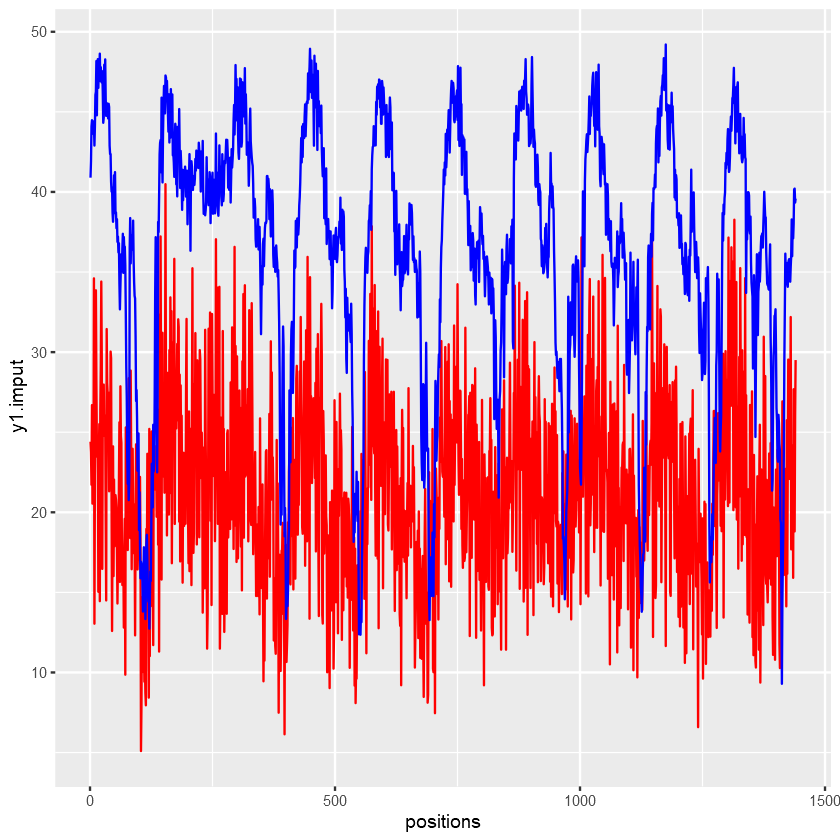

In [13]:
g1 <- ggplot(df, aes(positions))
g1 <- g1 + geom_line(aes(y=y1.imput), colour="red")
g1 <- g1 + geom_line(aes(y=y1.original), colour="blue")
print(g1)



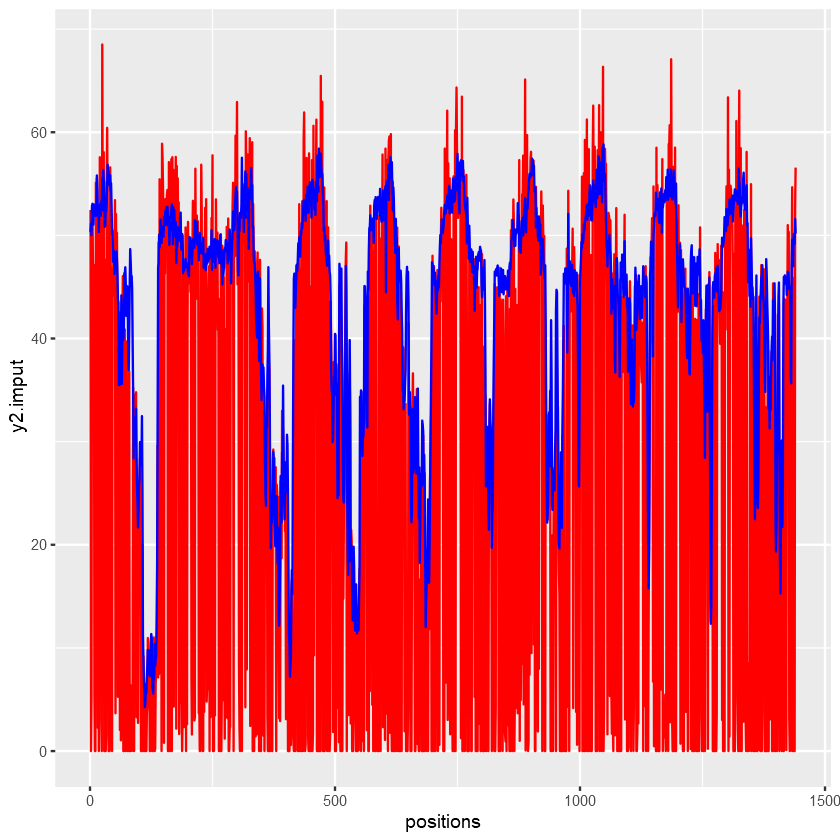

In [14]:
g2 <- ggplot(df, aes(positions))
g2 <- g2 + geom_line(aes(y=y2.imput), colour="red")
g2 <- g2 + geom_line(aes(y=y2.original), colour="blue")
print(g2)

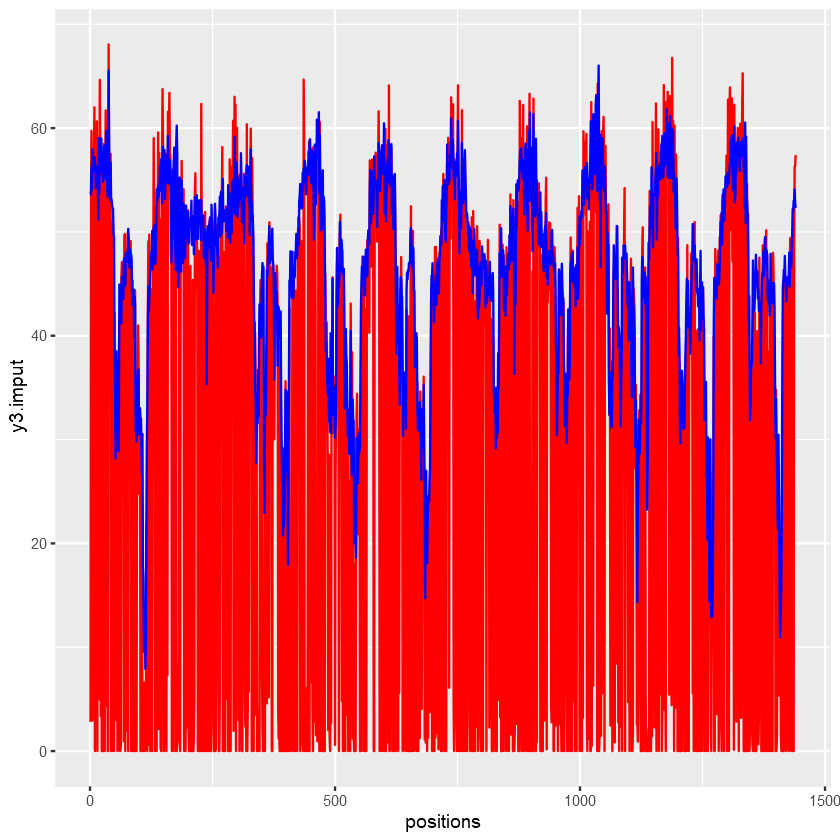

In [15]:
g3 <- ggplot(df, aes(positions))
g3 <- g3 + geom_line(aes(y=y3.imput), colour="red")
g3 <- g3 + geom_line(aes(y=y3.original), colour="blue")
print(g3)

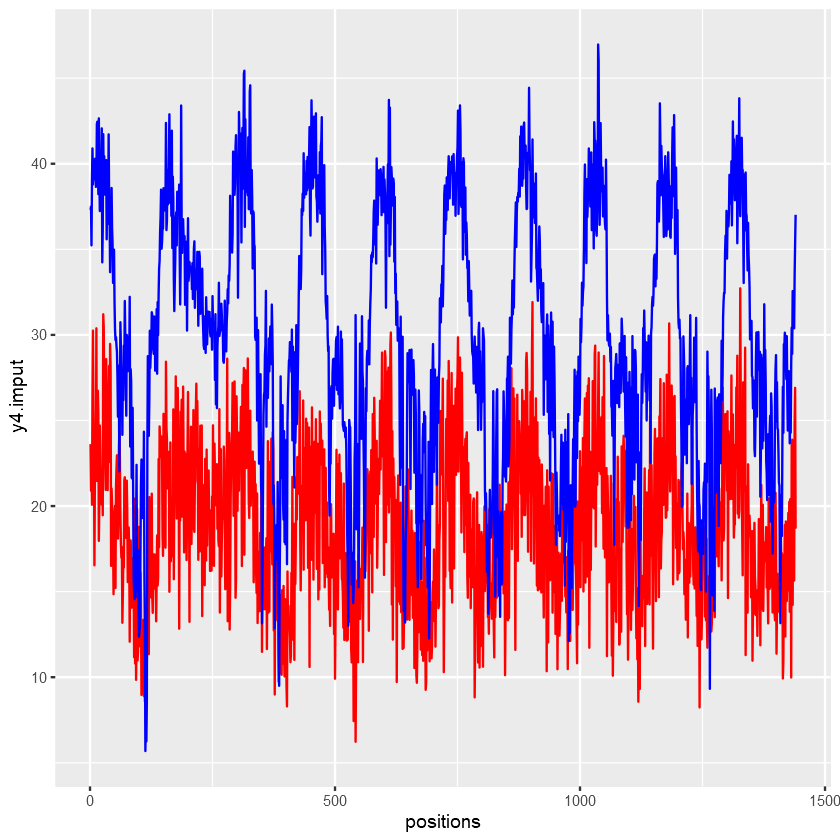

In [16]:
g4 <- ggplot(df, aes(positions))
g4 <- g4 + geom_line(aes(y=y4.imput), colour="red")
g4 <- g4 + geom_line(aes(y=y4.original), colour="blue")
print(g4)




[1] 28973

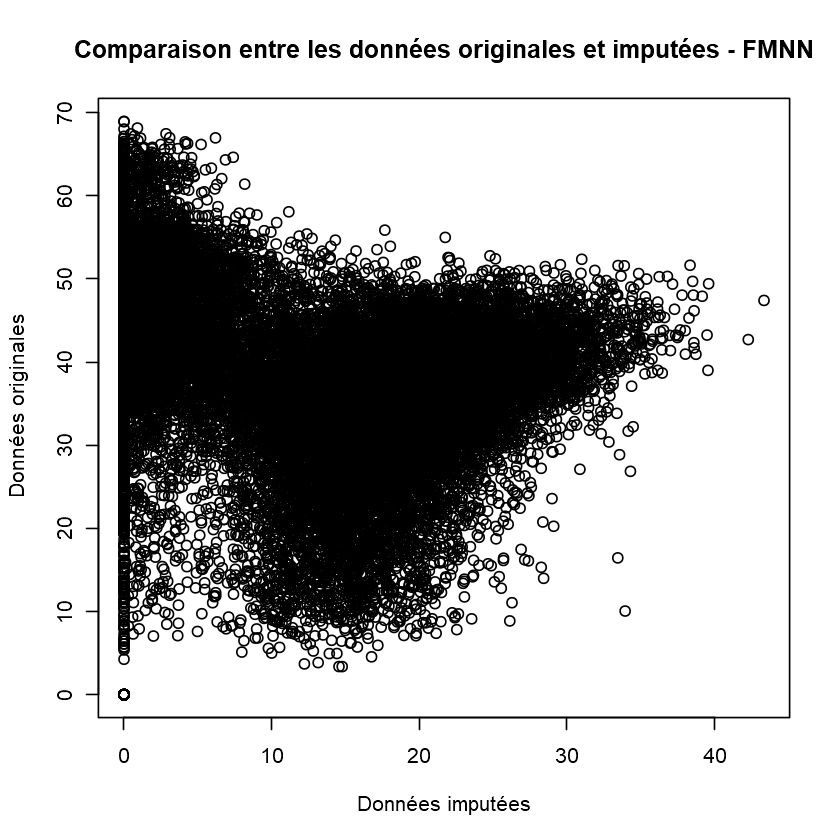

In [17]:
# Graphique de données position des  y

length(index)

x.imput <- mat_hat[c(index)]
y.original <- mat.complet[c(index)]

plot(x.imput, y.original, 
     xlab = "Données imputées",
     ylab = "Données originales",
     main = "Comparaison entre les données originales et imputées - FMNN")